In [1]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
from helpers import *
np.random.seed(13)

In [2]:
N = 500000
# Generate sufficiently scattered source signals
S = np.random.uniform(-1.1,1.1, size = (5,N))
S = S*(S>=-1)*(S<=1) + (S>1)*1 + (S<-1)*(-1)
# Number of Source and Mixtures
NumberofSources = S.shape[0]
NumberofMixtures = 8

# INPUT_STD = 0.35
# A = np.random.standard_normal(size=(NumberofMixtures,NumberofSources))
# X = A @ S
# for M in range(A.shape[0]):
#     stdx = np.std(X[M,:])
#     A[M,:] = A[M,:]/stdx * INPUT_STD

# # A = np.abs(A)
# X = A @ S
# Mixtures
# Generate Mxr random mixing from i.i.d N(0,1)
A=np.random.randn(NumberofMixtures,NumberofSources)
X=np.dot(A,S)
X=X+0.01*np.random.randn(X.shape[0],X.shape[1])
print('The following is the mixture matrix A')
display_matrix(A)

The following is the mixture matrix A


<IPython.core.display.Math object>

In [3]:
#ALGORITHM PARAMETERS
#Ry forgetting factor
lambday = 1 - 1e-5 /10
#Re forgetting factor
lambdae = 1 - 1e-6 /10

gamy = (1-lambday)/lambday
game = (1-lambdae)/lambdae

# W feedforward synapses learning step size
muW = 2e-3
# muW = 1e-6
# Output computation stepsize
muv = 1.0
# Display Periods
DISPLAY_PERIOD = 200
# Hopefield parameter
h = 1 / gamy
# Output Computation Iterations
NumberofOutputIterations = 250
# ALGORTITHM STATE INITIALIZATION
# Inverse output covariance
By = 5 * np.eye(NumberofSources)
# Inverse error covariance
Be = 100 * np.eye(NumberofSources)
# Feedforward Synapses
# W=np.eye(r,M)*2
# W = np.random.randn(NumberofSources,NumberofMixtures)/4
# Wu = np.zeros((NumberofSources,NumberofMixtures))

W = np.random.randn(NumberofSources,NumberofMixtures)
Wu = np.zeros((NumberofSources,NumberofMixtures))
# WScalings = 0.0033
# W = np.random.standard_normal(size = (NumberofSources, NumberofMixtures))
for k in range(W.shape[0]):
    W[k,:] =  W[k,:]/np.linalg.norm(W[k,:])
# WScalings = 0.0033
# W = np.random.standard_normal(size = (NumberofSources, NumberofMixtures))
# for k in range(W.shape[0]):
#     W[k,:] = WScalings * W[k,:]/np.linalg.norm(W[k,:])
# SIR list
SIRlist = np.zeros(N)
SIRflist = np.zeros(N)
erlist = np.zeros(N)
erflist = np.zeros(N)
Belist = np.zeros(N)
SIRflisto = 0
erflisto = 0

In [4]:
@njit
def run_neural_dynamics_antisparse(yk, yke, My, gamy, Be, game, vk, muv, n_iterations = 250,
                                   lr_start = 1.5, lr_stop = 0.001, tol = 1e-8):
    
    def ProjectOntoLInfty(X, thresh = 1.0):
        return X*(X>=-thresh)*(X<=thresh)+(X>thresh)*thresh-thresh*(X<-thresh)
    
    for j in range(n_iterations):
        muv = max(lr_start/(1 + j * 0.005), lr_stop)
        ykold = yk
        #Find error
        ek = yk - yke
        # Gradient of the entropy cost H(y)
        grady = gamy * np.dot(My, yk)
        # Gradient for H(yk|xk)
        grade = game * np.dot(Be, ek)
        # Overall gradient
        gradv = -vk + grady - grade
        # Update v
        vk = vk + muv * gradv / np.linalg.norm(gradv) / (j+1)
        
        yk = ProjectOntoLInfty(vk / (h * gamy))
        if np.linalg.norm(yk - ykold) < tol * np.linalg.norm(ykold):
            break
        
    return yk, ek

# @njit
# def run_neural_dynamics_antisparse(yk, yke, My, gamy, Be, game, vk, muv, n_iterations = 750, tol = 1e-8):
#     def ProjectOntoLInfty(X, thresh = 1.0):
#         return X*(X>=-thresh)*(X<=thresh)+(X>thresh)*thresh-thresh*(X<-thresh)
    
#     for j in range(n_iterations):
#         ykold = yk
#         #Find error
#         ek = yk - yke
#         # Gradient of the entropy cost H(y)
#         grady = gamy * np.dot(My, yk)
#         # Gradient for H(yk|xk)
#         grade = game * np.dot(Be, ek)
#         # Overall gradient
#         gradv = -vk + grady - grade
#         # Update v
#         vk = vk + muv * gradv / np.linalg.norm(gradv) / (j+1)
        
#         yk = ProjectOntoLInfty(vk / (h * gamy))
#         if np.linalg.norm(yk - ykold) < tol * np.linalg.norm(ykold):
#             break
        
#     return yk, ek

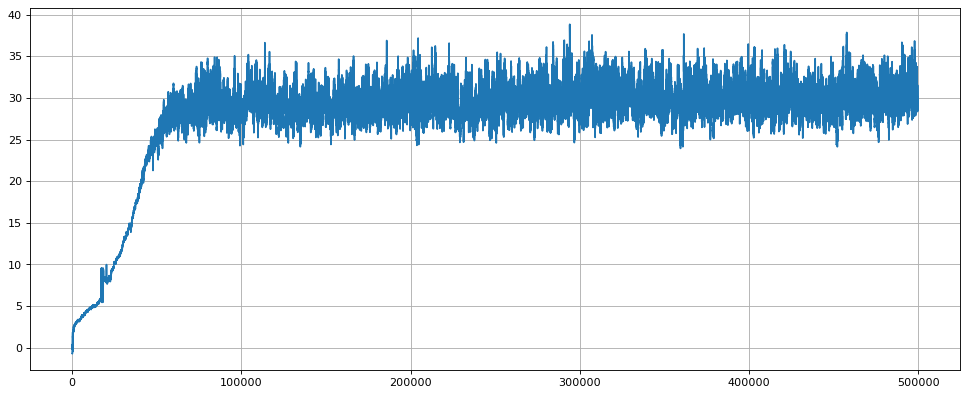

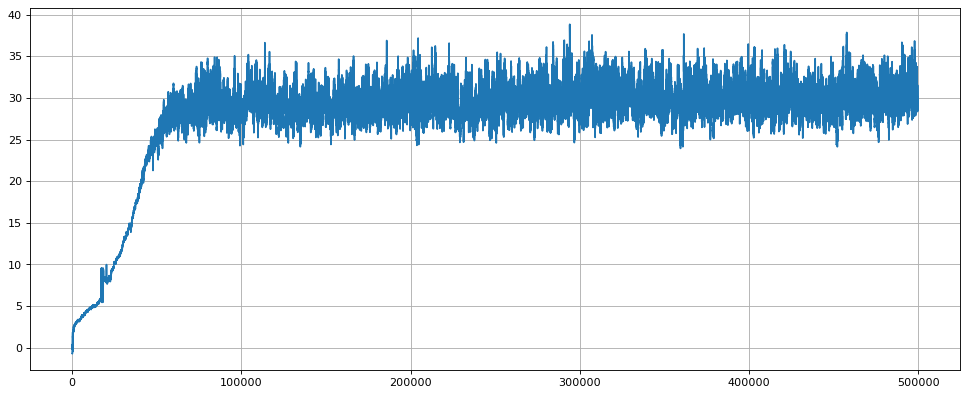

In [5]:
plt.figure(figsize = (15, 6), dpi = 80)
for k in range(N):
    # Get the current input
    xk = X[:,k]
    xk = np.reshape(xk, (NumberofMixtures, 1))
    # Initialize membrane voltage
    vk = np.zeros((NumberofSources, 1))
    # Initialize Output
    yk = 2.0 * np.random.rand(NumberofSources, 1) - 1.0;
    yk = np.random.uniform(-1.1,1.1, size = (NumberofSources,1))
#     yk = np.zeros((NumberofSources,1))
#     yk = yk/3
    vk = h * yk * gamy
#     vk = np.random.uniform(-1.1,1.1, size = (NumberofSources,1))
    yke = np.dot(W, xk)
    yk = yk/3
    # Compute output
    ynormlist = np.zeros(NumberofOutputIterations)
    # Output recurrent weights
    My = By + h * np.eye(NumberofSources)
    NumberofOutputIterations_ = np.int64(5+np.min([np.ceil(k/50000.0),NumberofOutputIterations]))

    t0 = time()
    yk, ek = run_neural_dynamics_antisparse(yk, yke, My, gamy, Be, game, vk, muv, 
                                            NumberofOutputIterations_)
    t1 = time()

#     Wu = 0.01 * np.dot(ek,xk.T)
    W = (1 - 1e-6) * W + muW * (np.dot(ek,xk.T) - Wu) #+ 0.0001 * np.random.randn(NumberofSources,NumberofMixtures)#/np.sqrt(k/100+1)
#     Wu = 0.01 * np.dot(ek,xk.T)#/10/100

    ee = np.dot(Be,ek)
    Be = 1 / lambdae * (Be - game * np.dot(ee, ee.T))
    # By
    zk = np.dot(By,yk)
    By = 1 / lambday * (By - gamy * np.dot(zk, zk.T))
    Wf = np.linalg.inv(game * Be - gamy * By) @ Be @ W * game
    SIRv,rankP = CalculateSIR(A, Wf)
    SIRlist[k] = SIRv 
    if (np.mod(k,DISPLAY_PERIOD) == 0):
        pl.clf()
        pl.plot(SIRlist[:k])
        pl.grid()
        clear_output(wait=True)
        display(pl.gcf())    

In [7]:
Y = Wf @ X
Y.shape, X.shape, S.shape

((5, 500000), (8, 500000), (5, 500000))

In [8]:
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T

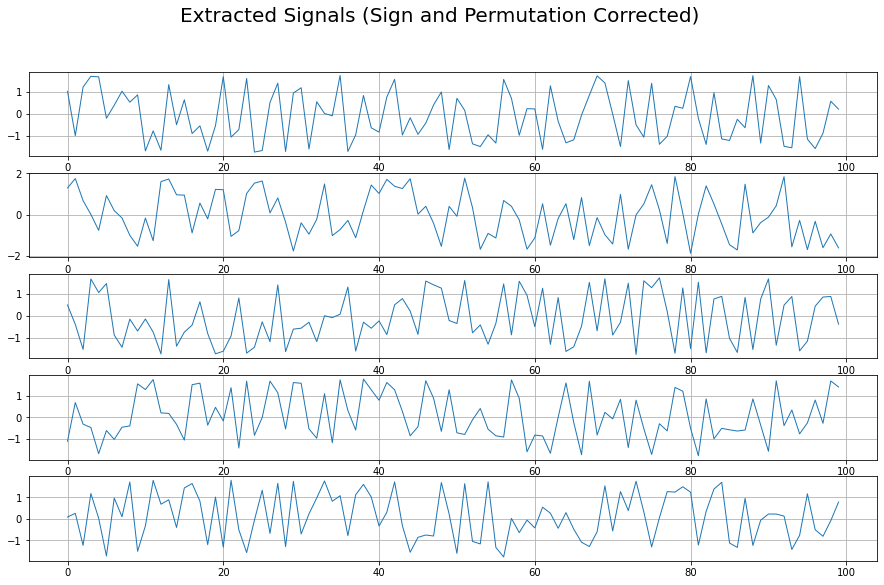

In [9]:
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)

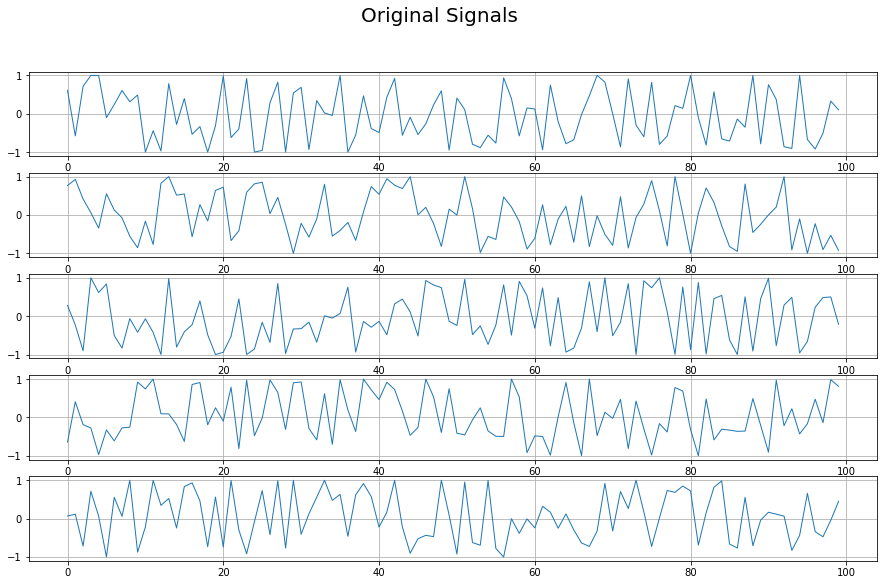

In [10]:
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)